# Visualizing Model Performance: Insights from "engine_efficientnet_MH.ipynb"

This notebook delves deep into the results generated by the model defined in [engine_efficientnet_MH.ipynb](https://github.com/DataBytes-Organisation/Project-Echo/tree/d4505bbd357e6ddae9a939f41416abcfa6e8fb40/src/Prototypes/engine/Transfer%20Learning%20Tasks/MH_EfficientNetV3). Our primary objective is to extract, analyze, and visually represent the key performance metrics of the model to gain a deeper understanding of its behavior and effectiveness.

The raw results from the "engine_efficientnet_MH.ipynb" model were meticulously extracted and stored in .txt format these .txt files are further converter into pandas dataframes. This notebook transforms these textual data points into comprehensive visualizations, spanning from line plots capturing the evolution of accuracy and loss over epochs, to intricate confusion matrices that highlight class-wise prediction nuances.

In [23]:
# Importing the required the libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [8]:
# Reading the contents
with open("/content/True Class, Predicted Class, Predicted Probability.txt", "r") as file:
    content = file.readlines()

# Displaying the first few lines to understand the structure
content[:10]


["Class names: ['Acanthagenys rufogularis', 'Acanthiza apicalis', 'Acanthiza chrysorrhoa', 'Acanthiza ewingii', 'Acanthiza inornata', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza robustirostris', 'Acanthiza uropygialis', 'Acanthorhynchus superciliosus', 'Acanthorhynchus tenuirostris', 'Acanthornis magna', 'Accipiter cirrocephalus', 'Accipiter fasciatus', 'Accipiter novaehollandiae', 'Acridotheres tristis', 'Acrocephalus australis', 'Adelotus brevis', 'Aegotheles cristatus', 'Aerodramus terraereginae', 'Aidemosyne modesta', 'Ailuroedus crassirostris', 'Ailuroedus maculosus', 'Alauda arvensis', 'Alectura lathami', 'Alisterus scapularis', 'Amaurornis moluccana', 'Amytornis whitei oweni', 'Anas castanea', 'Anas gracilis', 'Anas platyrhynchos (Domestic type)', 'Anas superciliosa', 'Anhinga novaehollandiae', 'Anser sp. (Domestic type)', 'Anthochaera carunculata', 'Anthochaera chrysoptera', 'Anthochaera paradoxa', 'Anthochaera phrygia', 'Anthu

In [9]:
# Filtering out the non-relevant lines and creating lists for each column
true_classes = []
predicted_classes = []
predicted_probabilities = []

# Skip initial lines with class names and log messages
data_start_line = content.index("True class      : Lewinia pectoralis\n")

for i in range(data_start_line, len(content), 3):
    true_classes.append(content[i].split(":")[1].strip())
    predicted_classes.append(content[i + 1].split(":")[1].strip())
    predicted_probabilities.append(float(content[i + 2].split(":")[1].strip()))

# Creating the DataFrame
df = pd.DataFrame({
    "True Class": true_classes,
    "Predicted Class": predicted_classes,
    "Predicted Probability": predicted_probabilities
})

df.head()


,True Class,Predicted Class,Predicted Probability
0,Lewinia pectoralis,Lewinia pectoralis,99.90
1,Acrocephalus australis,Acrocephalus australis,99.96
2,Psephotus haematonotus,Psephotus haematonotus,99.70
3,Acanthiza apicalis,Eopsaltria australis,77.57
4,Cracticus torquatus,Cracticus torquatus,99.97


In [10]:
with open("/content/Model sequential 1.txt", "r") as file:
    content_model = file.readlines()

# Displaying the first few lines to understand the structure
content_model[:10]

['Model: "sequential"\n',
 '_________________________________________________________________\n',
 ' Layer (type)                Output Shape              Param #   \n',
 '=================================================================\n',
 ' keras_layer (KerasLayer)    (None, 1000)              7200312   \n',
 '                                                                 \n',
 ' flatten (Flatten)           (None, 1000)              0         \n',
 '                                                                 \n',
 ' batch_normalization (Batch  (None, 1000)              4000      \n',
 ' Normalization)                                                  \n']

In [11]:
# Lists to hold the extracted data
layer_names = []
layer_types = []
output_shapes = []
param_counts = []

# Extracting the relevant information for each layer
for i in range(len(content_model)):
    line = content_model[i]
    if line.startswith(" ") and "None" in line:  # Indicates the start of a layer's details
        # Splitting the line to get individual details
        parts = line.split()
        layer_name = parts[0]
        layer_type = parts[1][1:-1]
        output_shape = parts[2]
        param_count = int(parts[-1].replace(',', ''))

        layer_names.append(layer_name)
        layer_types.append(layer_type)
        output_shapes.append(output_shape)
        param_counts.append(param_count)

# Creating the DataFrame
df_model = pd.DataFrame({
    "Layer Name": layer_names,
    "Layer Type": layer_types,
    "Output Shape": output_shapes,
    "Parameter Count": param_counts
})

df_model


,Layer Name,Layer Type,Output Shape,Parameter Count
0,keras_layer,KerasLayer,"(None,",7200312
1,flatten,Flatten,"(None,",0
2,batch_normalization,Batc,"(None,",4000
3,dense,Dense,"(None,",3843840
4,batch_normalization_1,Ba,"(None,",15360
5,dense_1,Dense,"(None,",7374720
6,batch_normalization_2,Ba,"(None,",7680
7,dropout,Dropout,"(None,",0
8,dense_2,Dense,"(None,",922080


In [15]:
def convert_training_log_to_dataframe(file_path):
    # Reading the contents of the file
    with open(file_path, "r") as file:
        content = file.readlines()

    # Lists to hold the extracted data
    epochs = []
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    # Temporary variables to hold current epoch's data
    current_epoch = None
    current_train_loss = None
    current_train_accuracy = None
    current_val_loss = None
    current_val_accuracy = None
    current_lr = None

    # Extracting the relevant information for each epoch
    for i in range(len(content)):
        line = content[i]

        # Extracting epoch number
        if line.startswith("Epoch"):
            current_epoch = int(line.split()[1].split("/")[0].replace(":", "").strip())
            continue

        # Extracting training details and validation details
        if "step - loss:" in line and "val_loss:" in line:
            # Extracting training loss and accuracy
            current_train_loss = float(line.split("loss:")[1].split("-")[0].strip())
            current_train_accuracy = float(line.split("accuracy:")[1].split("-")[0].strip())

            # Extracting validation loss, accuracy, and learning rate
            current_val_loss = float(line.split("val_loss:")[1].split("-")[0].strip())
            current_val_accuracy = float(line.split("val_accuracy:")[1].split("-")[0].strip())
            current_lr = float(line.split("lr:")[1].strip())

            # Adding the current epoch's data to the lists
            epochs.append(current_epoch)
            train_losses.append(current_train_loss)
            train_accuracies.append(current_train_accuracy)
            val_losses.append(current_val_loss)
            val_accuracies.append(current_val_accuracy)
            learning_rates.append(current_lr)

    # Ensure all lists have the same length
    min_length = min(len(epochs), len(train_losses), len(train_accuracies), len(val_losses), len(val_accuracies), len(learning_rates))
    epochs = epochs[:min_length]
    train_losses = train_losses[:min_length]
    train_accuracies = train_accuracies[:min_length]
    val_losses = val_losses[:min_length]
    val_accuracies = val_accuracies[:min_length]
    learning_rates = learning_rates[:min_length]

    # Creating the DataFrame
    df_training_logs = pd.DataFrame({
        "Epoch": epochs,
        "Training Loss": train_losses,
        "Training Accuracy": train_accuracies,
        "Validation Loss": val_losses,
        "Validation Accuracy": val_accuracies,
        "Learning Rate": learning_rates
    })

    return df_training_logs

In [16]:
file_path = "/content/Model sequential.txt"
df_training_logs = convert_training_log_to_dataframe(file_path)
print(df_training_logs.head())

   Epoch  Training Loss  Training Accuracy  Validation Loss  \
0      1         4.5466             0.2362           2.8442   
1      2         3.1907             0.3989           2.2259   
2      3         2.6476             0.4850           1.8784   
3      4         2.2679             0.5483           1.6561   
4      5         2.0012             0.5957           1.5274   

   Validation Accuracy  Learning Rate  
0               0.4556         0.0001  
1               0.5587         0.0001  
2               0.6325         0.0001  
3               0.6690         0.0001  
4               0.6924         0.0001  


## Line Plot - Training Accuracy Vs Validation Accuracy
This plot traces the progression of both training and validation accuracy as the epochs advance. By observing the trends and the gap between these two curves, one can deduce how well the model generalizes to unseen data.

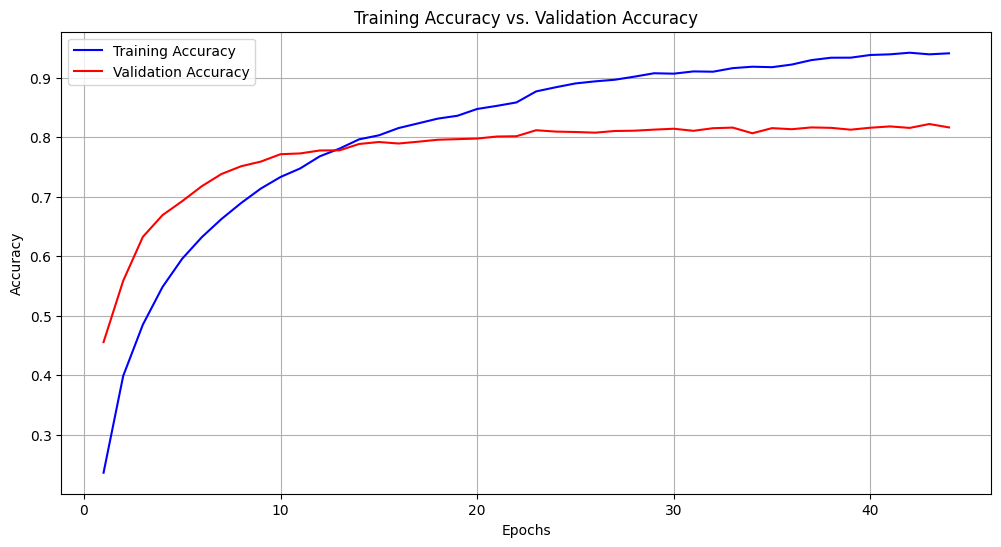

In [21]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_training_logs['Epoch'], df_training_logs['Training Accuracy'], label='Training Accuracy', color='blue')
plt.plot(df_training_logs['Epoch'], df_training_logs['Validation Accuracy'], label='Validation Accuracy', color='red')
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Line Plot - Training Loss Vs Validation Loss
This plot reflects the model's loss (or error) across epochs for both the training and validation datasets. A consistent decrease in loss values is a positive sign, implying the model is learning. However, a divergence between training and validation loss can suggest overfitting.


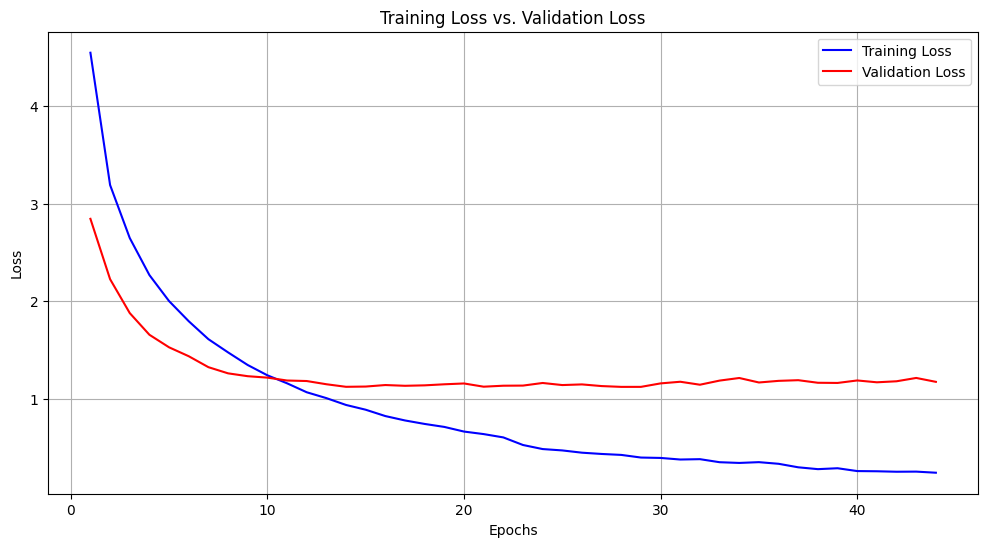

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df_training_logs['Epoch'], df_training_logs['Training Loss'], label='Training Loss', color='blue')
plt.plot(df_training_logs['Epoch'], df_training_logs['Validation Loss'], label='Validation Loss', color='red')
plt.title('Training Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrix - Model Predictions
The code snippet below computes and visualizes a confusion matrix for our model's predictions:
- X-axis (Predicted Classes): Represents the classes that our model predicted.
- Y-axis (True Classes): Represents the actual classes in our dataset.

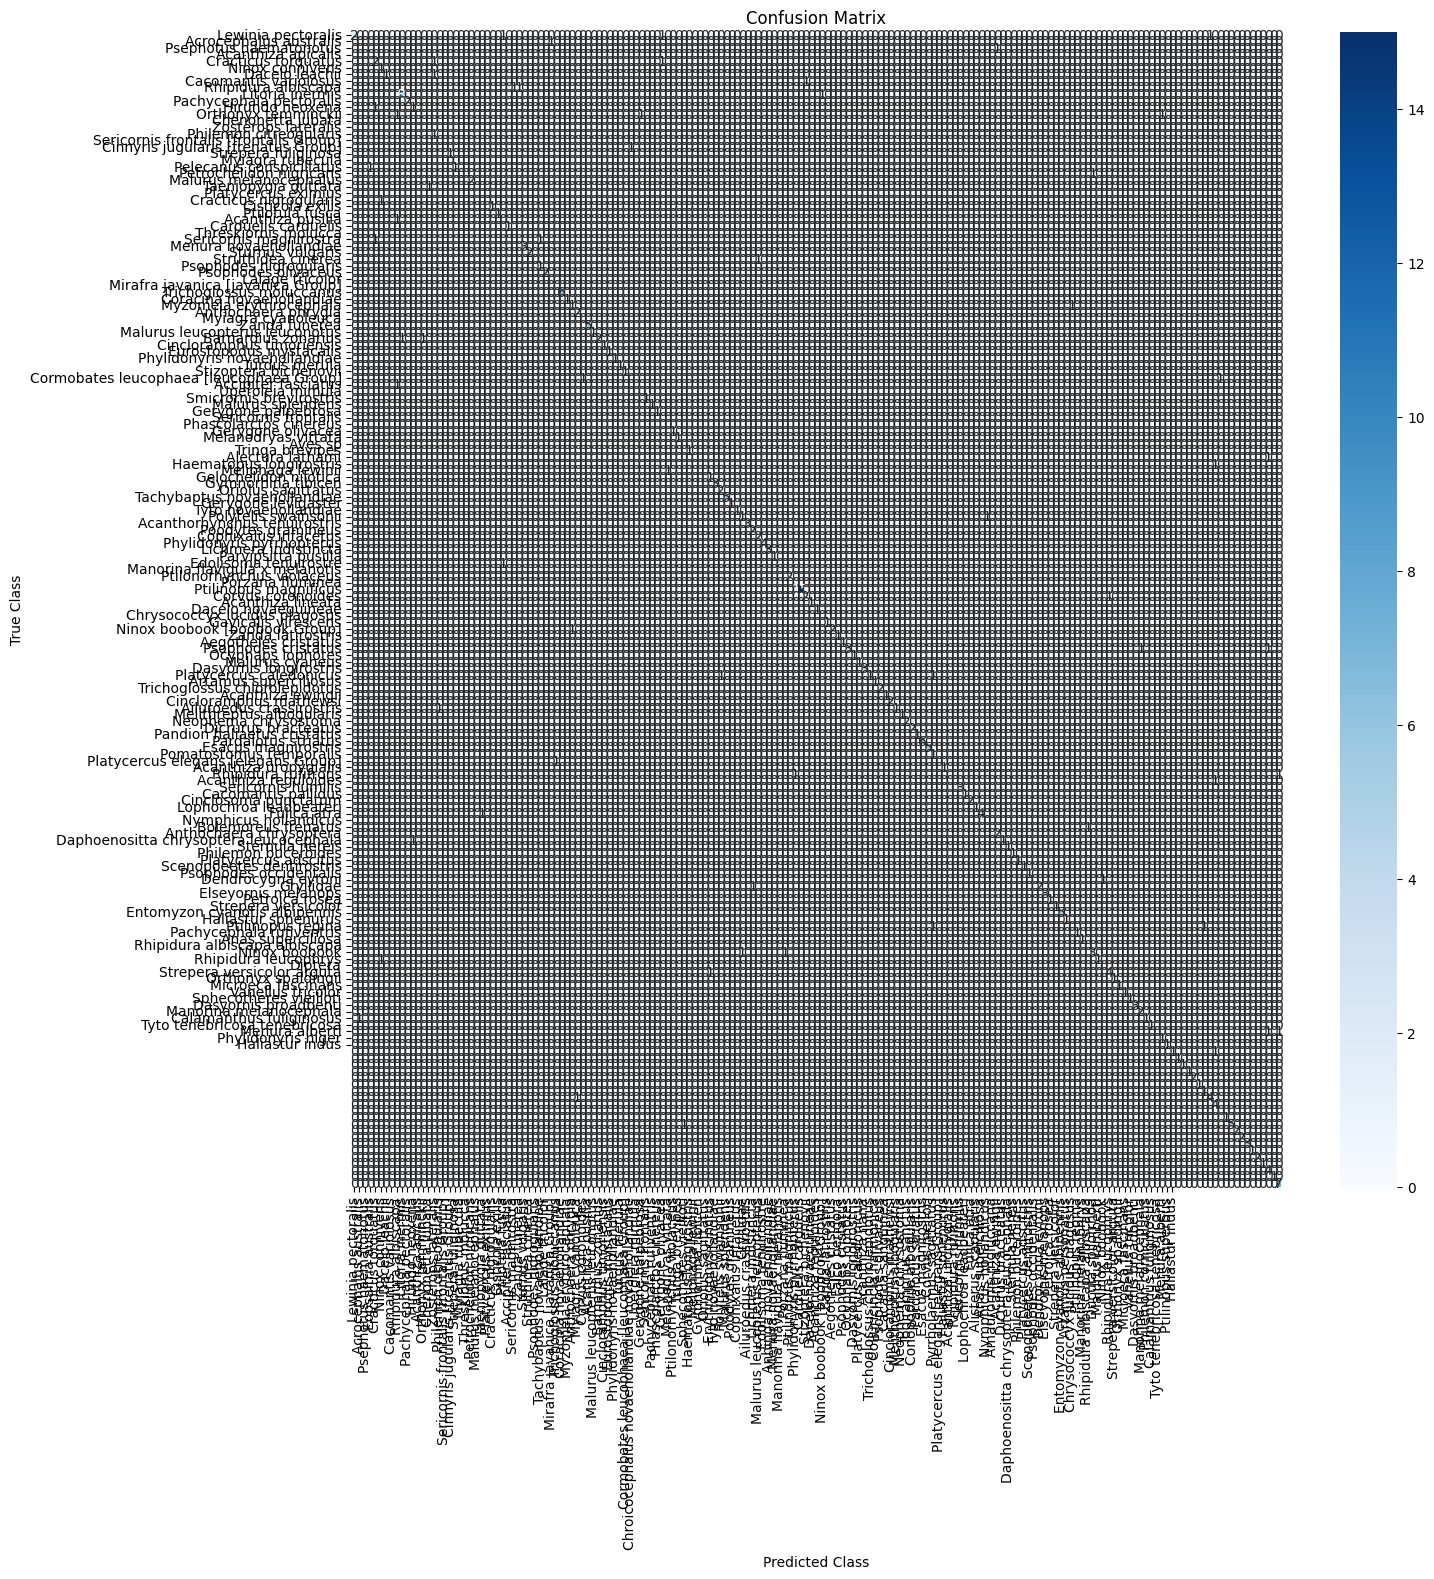

In [24]:
# Compute the confusion matrix
cm = confusion_matrix(df['True Class'], df['Predicted Class'])

# Plotting the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=df['Predicted Class'].unique(),
            yticklabels=df['True Class'].unique())
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix is showcasing all the classes and is getting crowded, we can consolidate this to 20 most frequent classes for better visualisation.

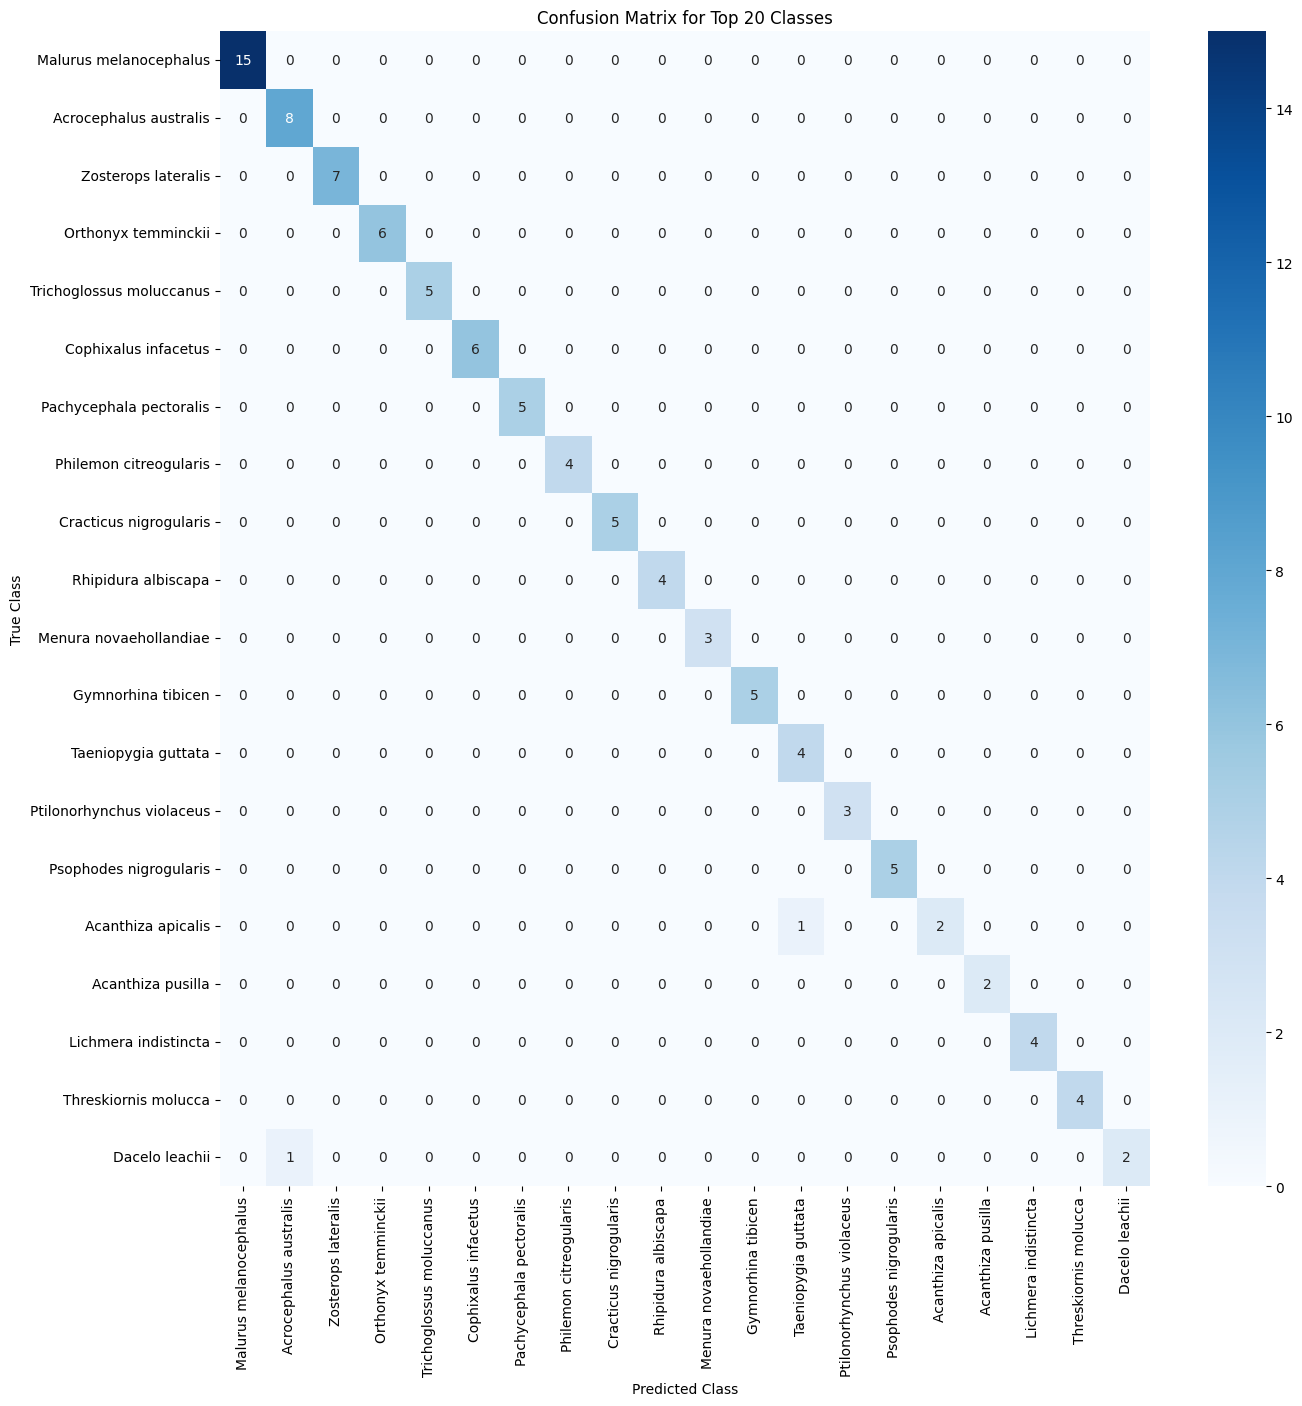

In [34]:
# Get the top 20 most frequent classes
top_20_classes = df['True Class'].value_counts().head(20).index

# Filter the confusion matrix to include only the top 20 classes
filtered_cm = confusion_matrix(
    df[df['True Class'].isin(top_20_classes)]['True Class'],
    df[df['True Class'].isin(top_20_classes)]['Predicted Class'],
    labels=top_20_classes  # Preserve class ordering
)

# Plotting the filtered confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(filtered_cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=top_20_classes,
            yticklabels=top_20_classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix for Top 20 Classes')
plt.show()


## Learning Rate over Epochs
In this plot, we visualize the learning rate used in each epoch. This can help in understanding the learning rate schedule (if any) applied during training, such as learning rate reductions.

The x-axis represents the epoch numbers, while the y-axis shows the corresponding learning rates. A decreasing curve might indicate strategies like learning rate annealing.

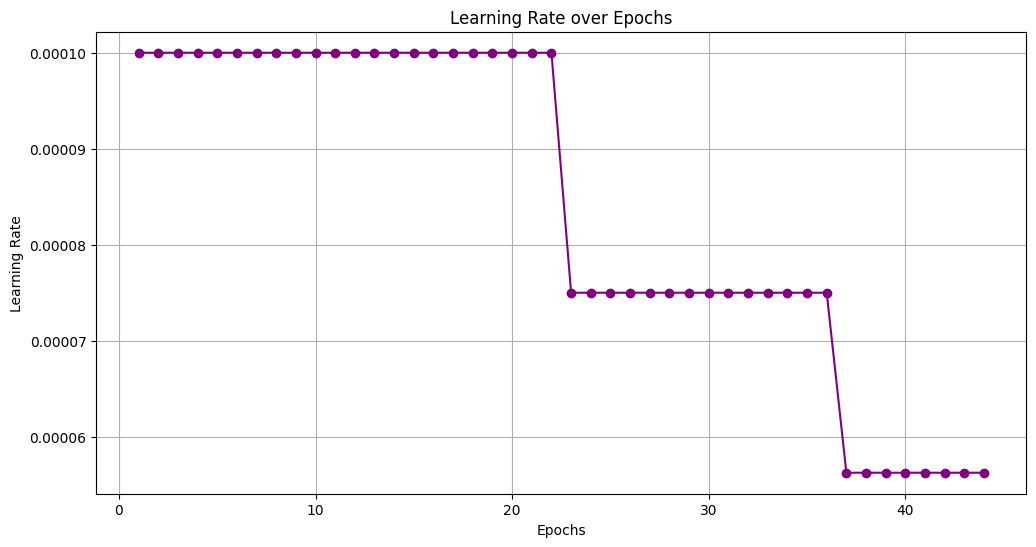

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df_training_logs['Epoch'], df_training_logs['Learning Rate'], '-o', color='purple')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

## Histogram showcasing predicted probabilites

This histogram provides a distribution of the predicted probabilities. It gives insights into the model's confidence level in its predictions. A peak near 1 would mean that for many samples, the model was very confident in its predictions.

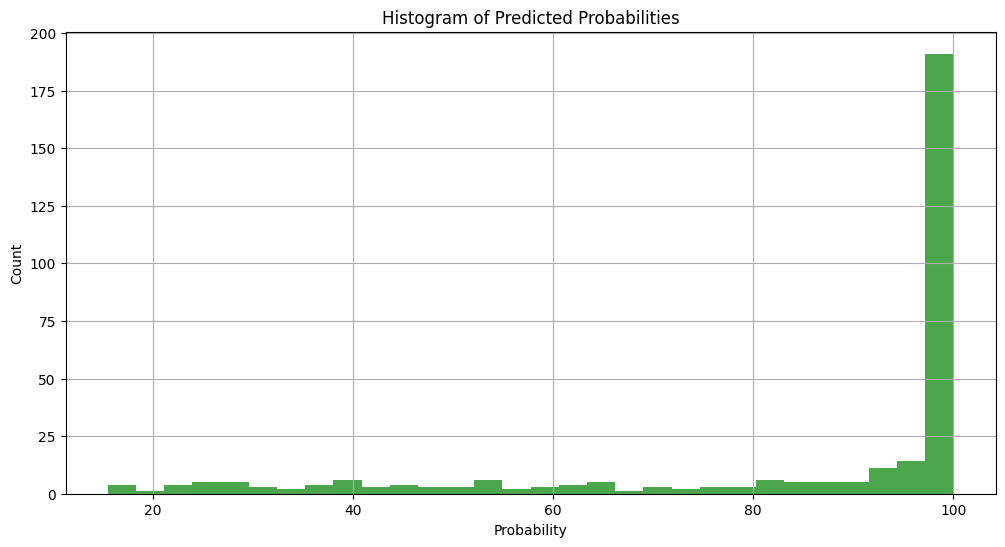

In [27]:
plt.figure(figsize=(12, 6))
plt.hist(df['Predicted Probability'], bins=30, color='green', alpha=0.7)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.grid(True)
plt.show()

## Bar Plot showcasing top 10 misclassified Classes
This bar plot showcases the classes that the model often misclassifies. The classes are on the x-axis, and the number of times they were misclassified is on the y-axis

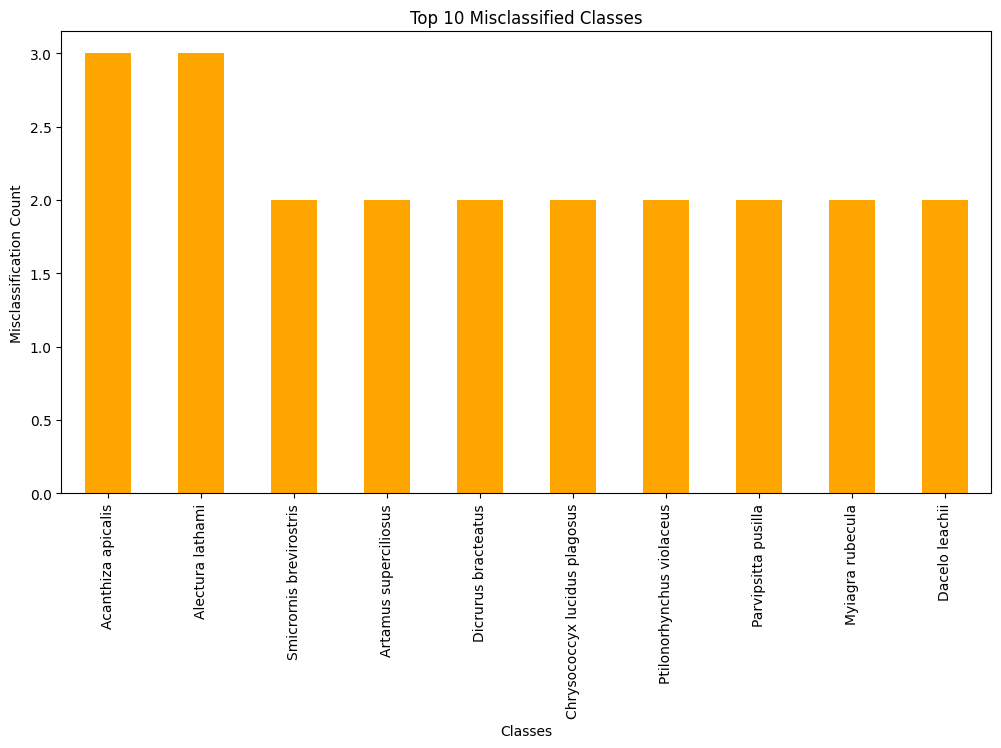

In [28]:
Misclassified = df[df['True Class'] != df['Predicted Class']]
misclass_counts = Misclassified['True Class'].value_counts().head(10)

misclass_counts.plot(kind='bar', figsize=(12, 6), color='orange')
plt.title('Top 10 Misclassified Classes')
plt.ylabel('Misclassification Count')
plt.xlabel('Classes')
plt.show()

## Box Plots for Loss and Accuracy Over Epochs

Box plots offer a summarized view of the distribution of data. In this context, they provide a snapshot of the spread and outliers for both loss and accuracy over epochs. Observing the interquartile range and potential outliers can give insights into the model's consistency and stability during training.

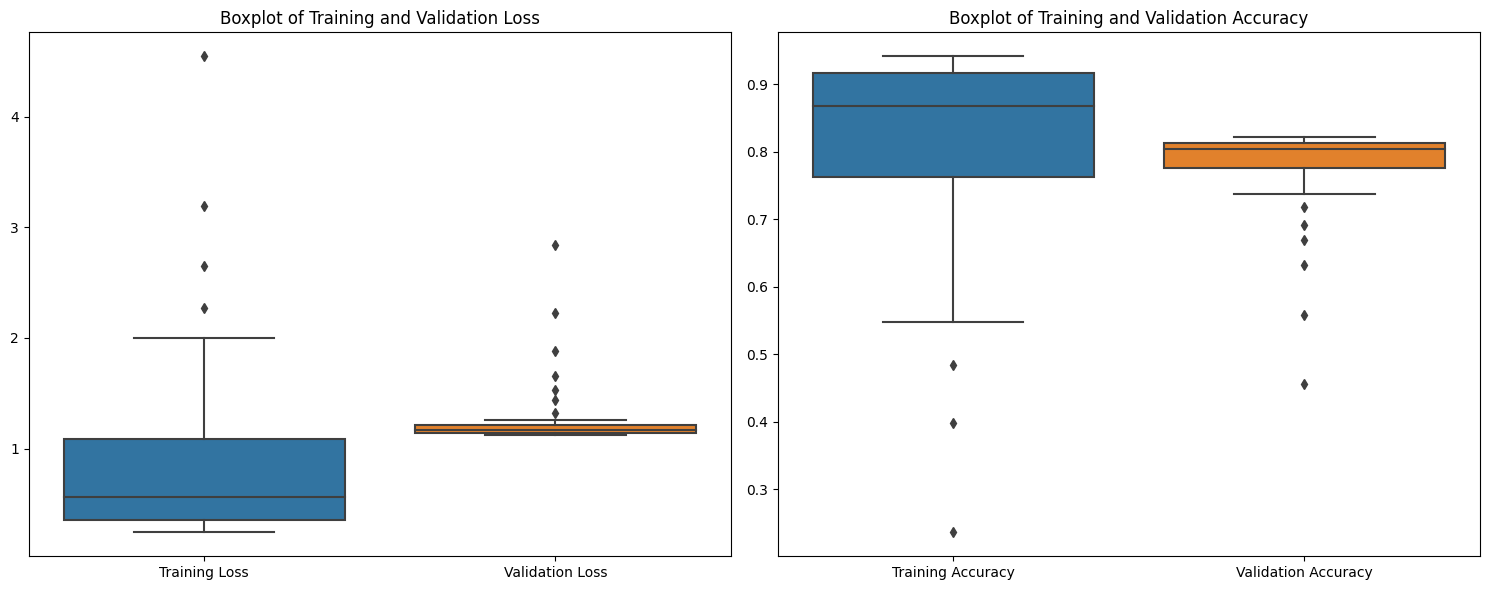

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(data=df_training_logs[['Training Loss', 'Validation Loss']], ax=ax[0])
ax[0].set_title('Boxplot of Training and Validation Loss')

sns.boxplot(data=df_training_logs[['Training Accuracy', 'Validation Accuracy']], ax=ax[1])
ax[1].set_title('Boxplot of Training and Validation Accuracy')

plt.tight_layout()
plt.show()

## Class-wise Accuracy for top 10 classes

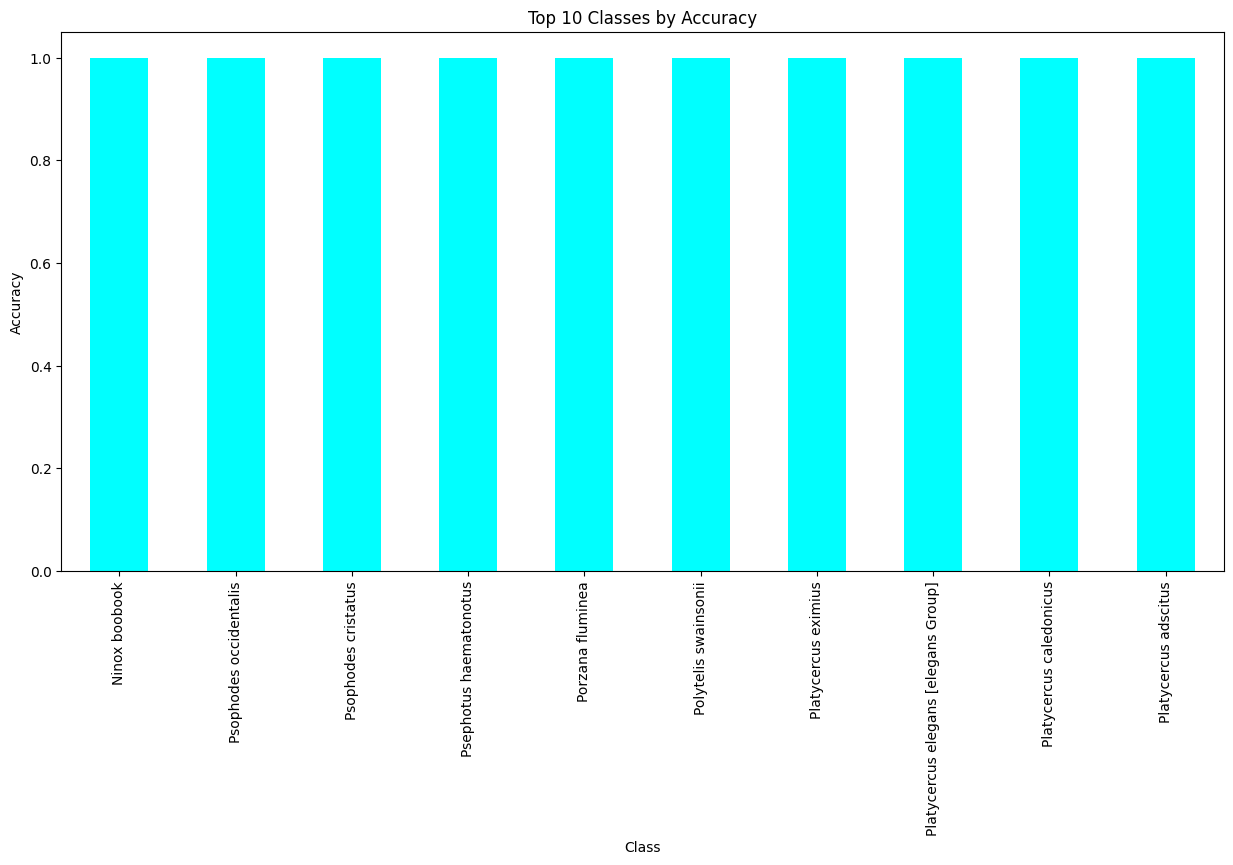

In [33]:
# Calculate accuracy for each class
correctly_classified = df[df['True Class'] == df['Predicted Class']]
accuracy_per_class = correctly_classified['True Class'].value_counts() / df['True Class'].value_counts()

# Take the top 10 classes with the highest accuracy
top_10_accuracy_per_class = accuracy_per_class.sort_values(ascending=False).head(10)

# Plotting
top_10_accuracy_per_class.plot(kind='bar', figsize=(15, 7), color='cyan')
plt.title('Top 10 Classes by Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.show()
